In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Zindi import *
from numpy.random import seed
seed(7)

In [2]:
X = np.load('train_ind_log_scaled_6m.npy').astype(np.float16)
y = np.load('train_labels.npy').astype(np.float16)

## Data Augmentation

In [3]:
#Generate new images rotated 90deg clockwise
Xaug1 = X.swapaxes(2,3)[:,:,:,::-1,:]
#generate new images rotated 180deg clockwise
Xaug2 = Xaug1.swapaxes(2,3)[:,:,:,::-1,:]
#Generate new images rotated 90deg counter-clockwise
Xaug3 = X.swapaxes(2,3)[:,:,::-1,:,:]

In [4]:
#Generate new images by 10px horizontal shift
Xaug4 = np.roll(X, 3, axis=2)
Xaug5 = np.roll(X, -3, axis=2)
#Generate new images by 10px vertical shift
Xaug6 = np.roll(X, 3, axis=3)
Xaug7 = np.roll(X, -3, axis=3)

In [5]:
#Stack all rotated inputs together, and labels.
Xaug = np.vstack((X, Xaug1, Xaug2, Xaug3, Xaug4, Xaug5, Xaug6, Xaug7))
yaug = np.hstack((y, y, y, y, y, y, y, y))
print("Augmented feature shape", Xaug.shape)
print("Augmented labels shape", yaug.shape)

Augmented feature shape (20416, 6, 40, 40, 27)
Augmented labels shape (20416,)


## Select only the 10 square pixels at the center

In [6]:
#Split Sentinel 2A channels and Terraclim channels (ignore QA60 channel from Sentinel)
#Select only B1, B5, B7 & B7 (all 4 calculated indices) from Sentinel 2A
#Select only pdsi, pr, tmmn, tmmx
X1 = Xaug[:,:,16:26,16:26,(0,1,9,10)]
X2_temp = Xaug[:,:,16:26,16:26,(16,18,23,24)]

In [7]:
#Shuffle augmented data once again
indices = np.arange(X1.shape[0])
np.random.shuffle(indices)
X1 = X1[indices]
X2_temp = X2_temp[indices]
y = yaug[indices]

In [8]:
#Terraclim values are same across pixels with rare differences. Lets takes only the mean values
X2 = np.mean(X2_temp, axis=(2,3))

In [9]:
print("X1 shape is: ", X1.shape)
print("X2 shape is: ", X2.shape)

X1 shape is:  (20416, 6, 10, 10, 4)
X2 shape is:  (20416, 6, 4)


In [10]:
#Split train, validation and test sets for Sentinel 2A channels
X1_train, y_train, X1_val, y_val, X1_test, y_test = train_val_test_split(X1, yaug, 200)

Train set shape:  (20016, 6, 10, 10, 4)
Train target shape:  (20016,)
Val set shape:  (200, 6, 10, 10, 4)
Val target shape:  (200,)
Test set shape:  (200, 6, 10, 10, 4)
Test target shape:  (200,)


In [11]:
#Split train, validation and test sets for Terraclim channels
X2_train, _, X2_val, _, X2_test, _ = train_val_test_split(X2, yaug, 200)

Train set shape:  (20016, 6, 4)
Train target shape:  (20016,)
Val set shape:  (200, 6, 4)
Val target shape:  (200,)
Test set shape:  (200, 6, 4)
Test target shape:  (200,)


## Build a NN

Two inputs - Sentinel 2A pixel values pass through a ConvLSTMN layer, and Terraclim values pass through an LSTM layer.

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten, Dropout, BatchNormalization, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [13]:
physical_devices = tf.config.list_physical_devices('GPU') 
physical_device = tf.config.experimental.list_physical_devices('GPU')
print("# of GPU's available: ", len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

# of GPU's available:  1


In [14]:
#Build a ConvLSTM model for Sentinel 2A channels
input_S2A = tf.keras.Input(shape=(None, 10, 10, 4))
convlstm_1 = ConvLSTM2D(filters=32,
               kernel_size=(5,5),
               strides=1,
               padding='valid',
               return_sequences=True,
               dropout=0.25)(input_S2A)
batch_S2_1 = BatchNormalization()(convlstm_1)
convlstm_2 = ConvLSTM2D(filters=64,
               kernel_size=(4,4),
               strides=1,
               padding='valid',
               return_sequences=True,
               dropout=0.25)(batch_S2_1)
batch_S2_2 = BatchNormalization()(convlstm_2)
convlstm_3 = ConvLSTM2D(filters=128,
               kernel_size=(3,3),
               strides=1,
               padding='valid',
               return_sequences=False,
               dropout=0.25)(batch_S2_2)
batch_S2_3 = BatchNormalization()(convlstm_3)
flat_S2_1 = Flatten()(batch_S2_3)
drop_S2_1 = Dropout(rate=0.5, seed=99)(flat_S2_1)
dense_S2_1 = Dense(units=64, activation='relu')(drop_S2_1)

#Build an LSTM model for Terraclim channels
input_TC = tf.keras.Input(shape=(None,4))
lstm_1 = LSTM(units=64, activation="tanh", kernel_initializer="glorot_uniform",
              return_sequences=True, dropout=0)(input_TC)
batch_TC_1 = BatchNormalization()(lstm_1)
lstm_2 = LSTM(units=64, activation="tanh", kernel_initializer="glorot_uniform",
              return_sequences=False, dropout=0)(batch_TC_1)
batch_TC_2 = BatchNormalization()(lstm_2)
drop_TC_1 = Dropout(rate=0.5, seed=99)(batch_TC_2)
dense_TC_1 = Dense(units=64, activation='relu')(drop_TC_1)

#Combine both model outputs
concat = Concatenate()([dense_S2_1, dense_TC_1])
dense_1 = Dense(units=64, activation='relu')(concat)
drop_1 = Dropout(rate=0.5, seed=99)(dense_1)
output = Dense(units=1, activation='linear')(drop_1)

model = tf.keras.Model([input_S2A, input_TC], output)

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 10, 10 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, None, 6, 6, 3 115328      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 6, 6, 3 128         conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, None, 3, 3, 6 393472      batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
#Compile model
opt = Adam(learning_rate=0.02)
loss = MeanSquaredError()
model.compile(optimizer=opt, loss=loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [17]:
#Set learning rate with callbacks
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
#Fit model with history
history = model.fit([X1_train, X2_train], y_train, epochs=15, batch_size=30, callbacks=callback, validation_data=([X1_val, X2_val], y_val))

Epoch 1/15
668/668 [==============================] - 86s 128ms/step - loss: 3.3405 - root_mean_squared_error: 1.8277 - val_loss: 4.1303 - val_root_mean_squared_error: 2.0323
Epoch 2/15
668/668 [==============================] - 84s 126ms/step - loss: 2.9691 - root_mean_squared_error: 1.7231 - val_loss: 4.0335 - val_root_mean_squared_error: 2.0084
Epoch 3/15
668/668 [==============================] - 84s 126ms/step - loss: 2.9563 - root_mean_squared_error: 1.7194 - val_loss: 4.0648 - val_root_mean_squared_error: 2.0161
Epoch 4/15
668/668 [==============================] - 84s 126ms/step - loss: 2.9532 - root_mean_squared_error: 1.7185 - val_loss: 4.1459 - val_root_mean_squared_error: 2.0361
Epoch 5/15
668/668 [==============================] - 84s 126ms/step - loss: 2.9532 - root_mean_squared_error: 1.7185 - val_loss: 4.1255 - val_root_mean_squared_error: 2.0311
Epoch 6/15
668/668 [==============================] - 84s 126ms/step - loss: 2.9513 - root_mean_squared_error: 1.7179 - val_l

In [18]:
model.evaluate([X1_test, X2_test], y_test)

7/7 [==============================] - 0s 22ms/step - loss: 3.4606 - root_mean_squared_error: 1.8603


[3.460556745529175, 1.8602571487426758]

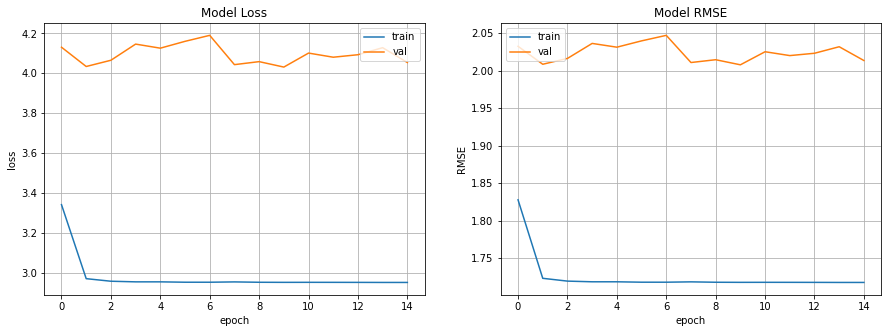

In [19]:
learning_plots(history)

## Results

This was a trial run to see if the log transform has any effect on the model's performance/ Looks like the model has large variance. Most likely, a much simpler/smaller model would perform to the expected level and not overfit the data. Further model fine tuning will not be required until more data exploration is done. Some other type of indices may need to be used for better results, instead of trying transformations.